In [1]:
import os
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import json
import numpy as np
from decouple import config

from functions import *

In [2]:
POSTGRES_USER = config('POSTGRES_USER')
POSTGRES_KEY = config('POSTGRES_KEY')

In [3]:
conn = psycopg2.connect(
   database="nepal", user=POSTGRES_USER, password=POSTGRES_KEY
)

In [4]:
sql = 'SELECT * FROM admin.npl_admbnda_adm0_nd_20201117'
df_adm0 = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM admin.npl_admbnda_adm1_nd_20201117'
df_adm1 = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM admin.npl_admbnda_adm2_nd_20201117'
df_adm2 = gpd.read_postgis(sql, conn)
df_adm1['id'] = df_adm1.index
sql = 'SELECT * FROM admin.npl_admbnda_districts_nd_20201117'
df_dist = gpd.read_postgis(sql, conn)

<AxesSubplot:>

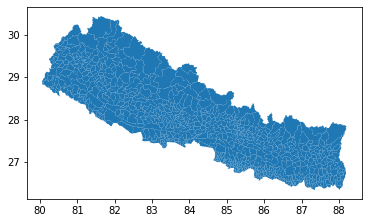

In [5]:
df_adm2.plot()

In [6]:
sql = 'SELECT * FROM power_network.substations_georeferenced'
df_sub = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM power_network.hv_lines_georeferenced'
df_hv = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM power_network.micro_hydropower'
df_mh = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM power_network.distribution_coverage'
df_dist = gpd.read_postgis(sql, conn)

<AxesSubplot:>

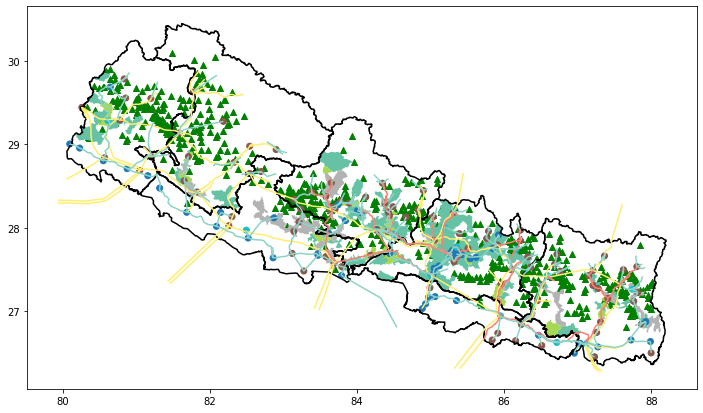

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
df_adm1.boundary.plot(color='black', ax=ax)
df_hv.plot(column='voltage', cmap='Set3', ax=ax)
df_mh.plot(marker="^", color='green', ax=ax)
df_dist.plot(column='voltage', cmap='Set2', ax=ax)
df_sub.plot(column='status', ax=ax)

## Raster analysis

In [8]:
rasterize(df_sub.to_crs(3395).loc[df_sub['status']=='E'], 'data/population_npl_2018-10-01_1km.tif', 
          'temp/rasterized_sub.tif', compression='DEFLATE')
# reproject_raster('temp/rasterized.tif', 3395, 'temp/rasterized_reproj.tif', 'DEFLATE')
proximity_raster('temp/rasterized_sub.tif', 'temp/output_sub.tif', [1], 'DEFLATE')
mask_raster('temp/output_sub.tif', df_adm0.to_crs(3395), 
            'temp/output_masked_sub.tif', -9999, 'DEFLATE')

In [9]:
df_hv_buffer = df_hv.copy().to_crs(3395)
df_hv_buffer['geom'] = df_hv_buffer['geom'].buffer(1)

rasterize(df_hv_buffer.loc[df_hv_buffer['status']=='E'], 'data/population_npl_2018-10-01_1km.tif', 'temp/rasterized_hv.tif', 
          value='voltage', compression='DEFLATE', dtype='uint16', all_touched=True)
proximity_raster('temp/rasterized_hv.tif', 'temp/output_hv.tif', [132, 220, 400], 'DEFLATE')
mask_raster('temp/output_hv.tif', df_adm0.to_crs(3395), 
            'temp/output_masked_hv.tif', -9999, 'DEFLATE')

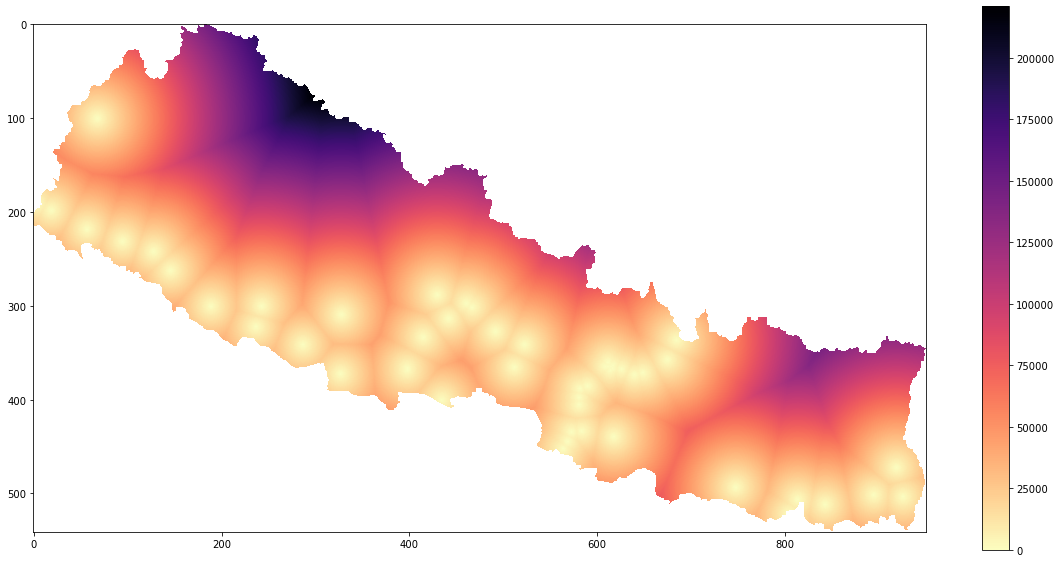

In [10]:
with rasterio.open('temp/output_masked_sub.tif') as src:
    raster = src.read(1)
    raster[raster<0] = np.nan
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(raster, cmap='magma_r')
plt.colorbar(shrink=0.5)

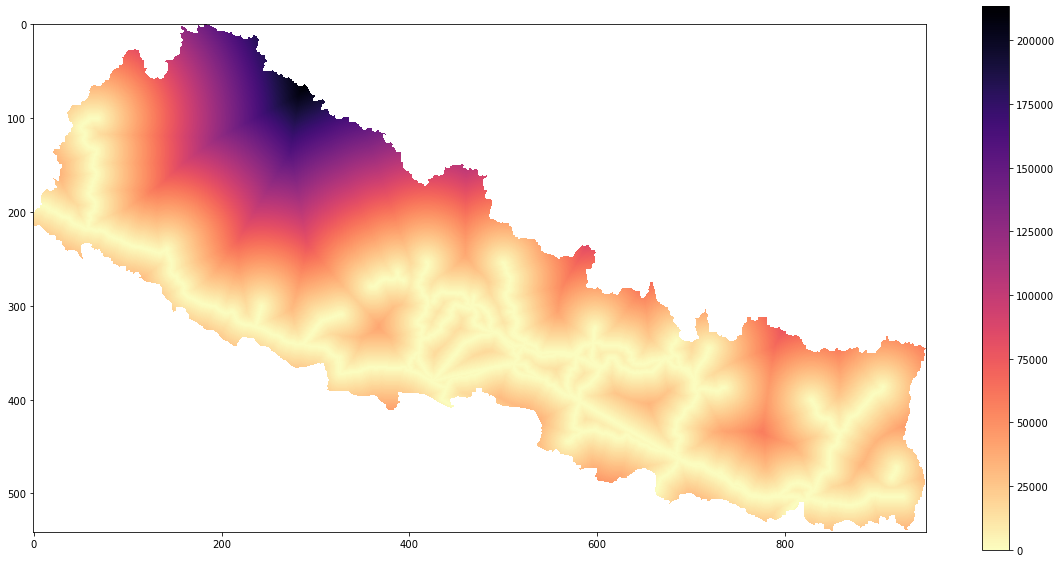

In [11]:
with rasterio.open('temp/output_masked_hv.tif') as src:
    raster = src.read(1)
    raster[raster<0] = np.nan
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(raster, cmap='magma_r')
plt.colorbar(shrink=0.5)

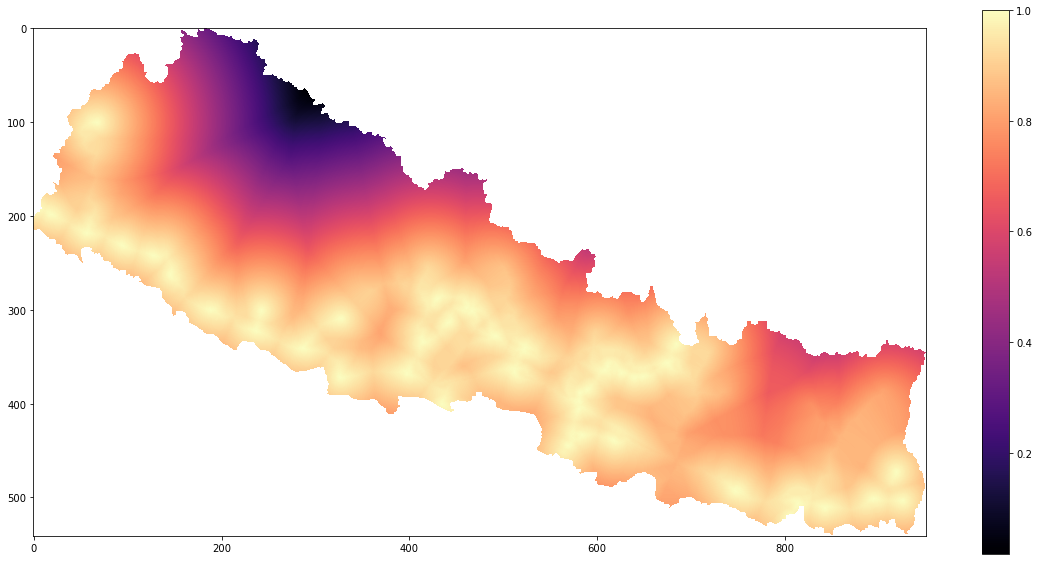

In [12]:
rasters = [1 - normalize('temp/output_masked_sub.tif'), 
           1 - normalize('temp/output_masked_hv.tif')]
weights = [1, 1]

supply_index = index(rasters, weights)
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(supply_index, cmap='magma')
plt.colorbar(shrink=0.5)

In [13]:
sql = 'SELECT * FROM places.education_facilities'
df_edu = gpd.read_postgis(sql, conn)

rasterize(df_edu.to_crs(3395), 'data/population_npl_2018-10-01_1km.tif', 'temp/rasterized_edu.tif', 
          compression='DEFLATE')
proximity_raster('temp/rasterized_edu.tif', 'temp/output_edu.tif', [1], 'DEFLATE')
mask_raster('temp/output_edu.tif', df_adm0.to_crs(3395), 
            'temp/output_masked_edu.tif', -9999, 'DEFLATE')

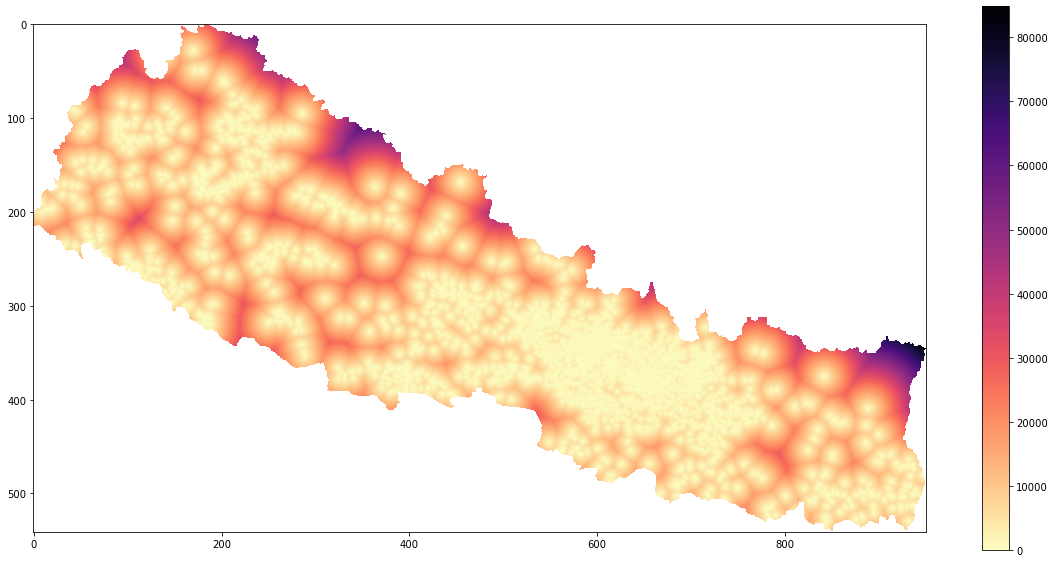

In [14]:
with rasterio.open('temp/output_masked_edu.tif') as src:
    raster = src.read(1)
    raster[raster<0] = np.nan
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(raster, cmap='magma_r')
plt.colorbar(shrink=0.5)

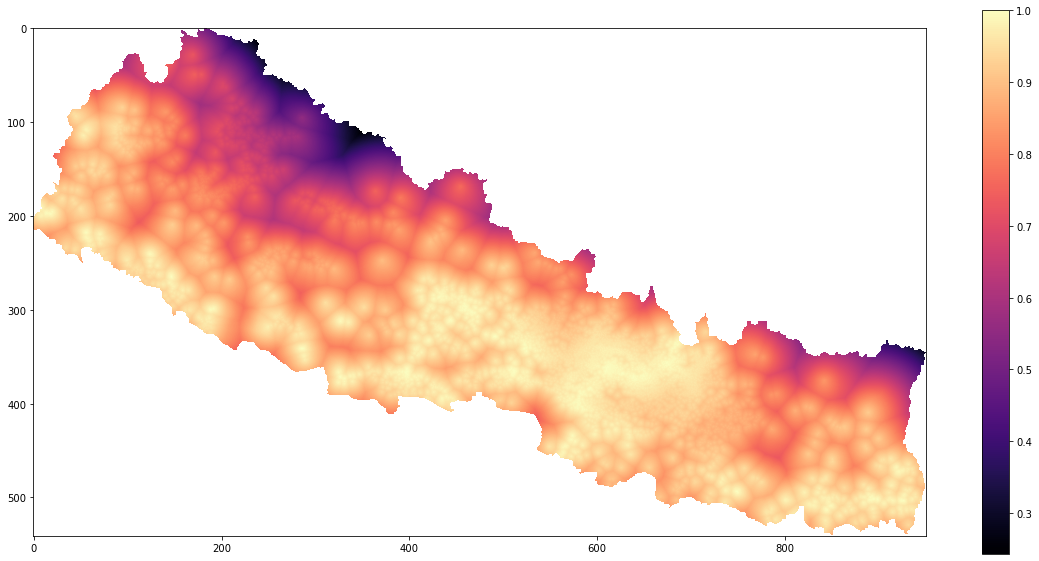

In [15]:
rasters = [1 - normalize('temp/output_masked_edu.tif')]
weights = [1]

demand_index = index(rasters, weights)
w_s = 1
w_d = 1
ccp_index = (w_s * supply_index + w_d * demand_index) / (w_s + w_d)
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(ccp_index, cmap='magma')
plt.colorbar(shrink=0.5)

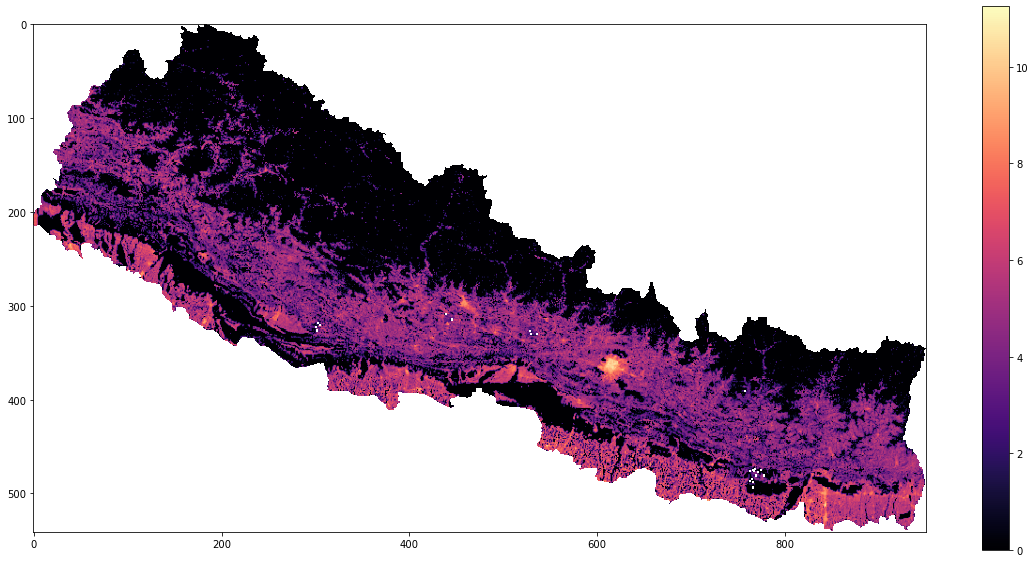

In [16]:
with rasterio.open('data/population_npl_2018-10-01_1km.tif') as src:
    raster = src.read(1)
    raster[raster==0] = np.nan
    raster[raster>0] = np.log(raster[raster>0])
    raster = np.nan_to_num(raster, nan=0)
    raster[raster<0] = np.nan
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(raster, cmap='magma')
plt.colorbar(shrink=0.5)

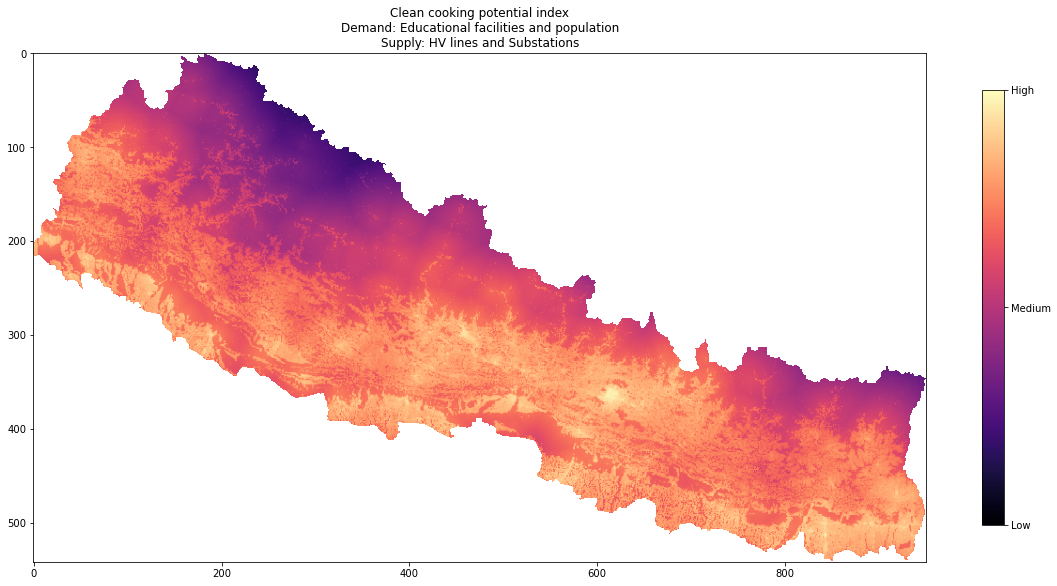

In [17]:
with rasterio.open('data/population_npl_2018-10-01_1km.tif') as src:
    population = src.read(1)
    population[population==0] = np.nan
    population[population>0] = np.log(population[population>0])
    population = np.nan_to_num(population, nan=0)
    population[population<0] = np.nan

    population = population / (np.nanmax(population) - np.nanmin(population))
    population = np.nan_to_num(population, nan=0)

rasters = [1 - normalize('temp/output_masked_edu.tif'),
           population]
weights = [1, 1]

demand_index = index(rasters, weights)
w_s = 1
w_d = 1
ccp_index = (w_s * supply_index + w_d * demand_index) / (w_s + w_d)
    
fig, ax = plt.subplots(1, 1)
cax = ax.imshow(ccp_index, cmap='magma', vmin=0, vmax=1)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
plt.title('Clean cooking potential index\nDemand: Educational facilities and population\nSupply: HV lines and Substations')
fig.set_size_inches(20, 10)
fig.savefig("clean_cooking_potential.png", dpi=300)

In [19]:
with rasterio.open('data/population_npl_2018-10-01_1km.tif') as src:
    out_meta = src.meta

with rasterio.open('ccp_index.tif', "w", **out_meta) as dest:
    dest.write(ccp_index, indexes=1)